# Part 3: Object Detection

In [3]:
from snowflake.snowpark import Session
from snowflake.snowpark import functions as F
from src.utils.image_plotting import show_images_from_df, show_object_detections_from_df
from src.utils.huggingface_helper import download_huggingface_model
from getpass import getpass
from cachetools import cached
from snowflake.snowpark.functions import udf
from snowflake.snowpark import types as T

In [4]:
# Creating Snowpark Session
sf_connection = {
    "account": "sfseeurope-prod_demo_gorkow",
    "user": getpass(),
    "password": getpass(),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH"
}
session = Session.builder.configs(sf_connection).create()

In [5]:
# Create a new database
session.sql('CREATE OR REPLACE DATABASE IMAGES').collect()

# Create a Snowflake Stage and enable the Directory Table
session.sql("""CREATE OR REPLACE STAGE IMAGE_FILES
                DIRECTORY = (ENABLE = TRUE AUTO_REFRESH = FALSE) 
                ENCRYPTION = (TYPE = 'SNOWFLAKE_SSE') 
                COMMENT='Stage to store Image Files'""").collect()

# Upload JPG-Files from a local folder to the Snowflake Stage
session.file.put(local_file_name='../resources/image_object_detections/*.jpeg',
                 stage_location='@IMAGE_FILES', 
                 auto_compress=False, 
                 overwrite=True)

# Update the Directory Table (can be automated via Snowflake Tasks)
session.sql('ALTER STAGE IMAGE_FILES REFRESH').collect()

[Row(file='stages/022caac8-7206-4df5-b7d3-ab4089406eae/cat-dog.jpeg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/022caac8-7206-4df5-b7d3-ab4089406eae/airplane.jpeg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/022caac8-7206-4df5-b7d3-ab4089406eae/crosswalk.jpeg', status='REGISTERED_NEW', description='File registered successfully.')]

In [6]:
# Create a Snowpark DataFrame for the Directory Table
image_df = session.sql("SELECT * FROM DIRECTORY(@IMAGE_FILES)")
image_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RELATIVE_PATH"  |"SIZE"  |"LAST_MODIFIED"            |"MD5"                             |"ETAG"                            |"FILE_URL"                                          |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|airplane.jpeg    |32744   |2023-06-20 03:01:43-07:00  |313bb5ccff9014628991c591fb1a3ede  |313bb5ccff9014628991c591fb1a3ede  |https://job14991.snowflakecomputing.com/api/fil...  |
|cat-dog.jpeg     |199411  |2023-06-20 03:01:45-07:00  |f441c99ee20df420c7da76d6b3e7eaac  |f441c99ee20df420c7da76d6b3e7eaac  |https://job14991.snowflakecomputing.com/api/fil...  |
|crosswalk.jpeg   |645186  |2023-06-20 03:01:47-07:00  |156163359ff42478808244060ba51a1c  |156163359

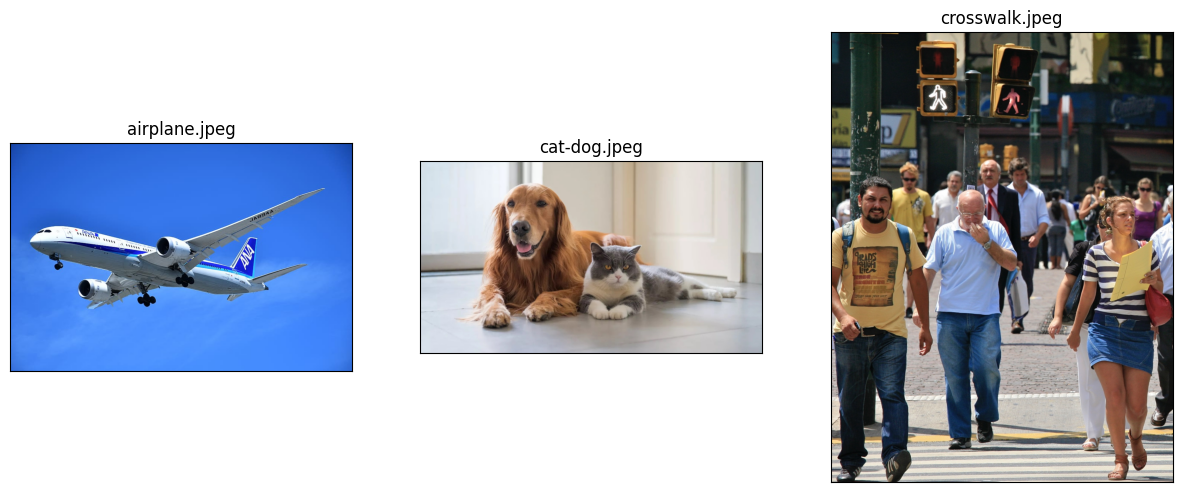

In [7]:
show_images_from_df(image_df, stage='@IMAGE_FILES', ncol=4, figsize=(15,10))

In [8]:
# Create a Snowflake stage to store model files
session.sql('CREATE STAGE IF NOT EXISTS MODELS').collect()

# Download model files from Huggingface into Snowflake stage
model_files = download_huggingface_model(
    session=session, 
    repo_id='hustvl/yolos-small', 
    framework='pytorch', 
    stage_location='@MODELS'
    )

# List model files in stage
session.sql('LS @MODELS').show()

Uploaded file:README.md
Uploaded file:config.json
Uploaded file:preprocessor_config.json
Uploaded file:pytorch_model.bin
-------------------------------------------------------------------------------------------------------------------------------------
|"name"                                              |"size"     |"md5"                             |"last_modified"                |
-------------------------------------------------------------------------------------------------------------------------------------
|models/hustvl/yolos-small/README.md                 |4176       |5c2450bae1a458e83232ed8f5797afb1  |Tue, 20 Jun 2023 10:01:58 GMT  |
|models/hustvl/yolos-small/config.json               |4144       |c5ad9205c4d8be5bf7625bb6409bae00  |Tue, 20 Jun 2023 10:01:59 GMT  |
|models/hustvl/yolos-small/preprocessor_config.json  |288        |33df5ae4281a4f80ca0d17e8deb41293  |Tue, 20 Jun 2023 10:02:00 GMT  |
|models/hustvl/yolos-small/pytorch_model.bin         |122806176  |038f35332

In [9]:
# Create a Snowflake stage to store the function
session.sql('CREATE STAGE IF NOT EXISTS FUNCTIONS').collect()

# Function to load and cache the model
@cached(cache={})
def load_transformer_model(import_dir: str)-> object:
    from transformers import pipeline
    transformer_pipeline = pipeline('object-detection', import_dir, import_dir)
    return transformer_pipeline

# Function to score images
@udf(name="DETECT_OBJECTS", 
     is_permanent=True, 
     stage_location='@FUNCTIONS', 
     replace=True, 
     session=session, 
     packages=['snowflake-snowpark-python','pillow','pytorch==1.12.1',
               'transformers==4.24.0','cachetools==4.2.2'], 
     imports=model_files)
def score_transformer_model(datafile: str) -> T.Variant:
    import sys
    from PIL import Image
    from snowflake.snowpark.files import SnowflakeFile
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    pipeline = load_transformer_model(import_dir)
    # Dynamic File Access in UDFs
    with SnowflakeFile.open(datafile, 'rb') as f:
        img = Image.open(f)
        return pipeline(img)

The version of package snowflake-snowpark-python in the local environment is 1.5.0, which does not fit the criteria for the requirement snowflake-snowpark-python. Your UDF might not work when the package version is different between the server and your local environment
The version of package pillow in the local environment is 9.5.0, which does not fit the criteria for the requirement pillow. Your UDF might not work when the package version is different between the server and your local environment
package pytorch is not installed in the local environmentYour UDF might not work when the package is installed on the server but not on your local environment.


In [10]:
# Create a scoped URL for secure dynamic file access 
object_detections_df = image_df.with_column('SCOPED_URL', F.call_builtin('BUILD_SCOPED_FILE_URL', F.lit('@IMAGE_FILES'), F.col('RELATIVE_PATH')))

# Detect objects in images
object_detections_df = object_detections_df.with_column('OBJECTS', score_transformer_model("SCOPED_URL"))

# Save the results
object_detections_df.write.save_as_table('OBJECTS', mode='overwrite')

In [11]:
# Read results
object_detections_df = session.table('OBJECTS')

# Flatten objects into multiple rows
object_detections_df = object_detections_df.join_table_function('FLATTEN', F.col('OBJECTS')).drop(['OBJECTS','SEQ','KEY','PATH','INDEX','THIS'])

# Extract values per object into separate columns
object_detections_df = object_detections_df.with_column('OBJECT_LABEL', F.col('VALUE')['label'].cast(T.StringType()))
object_detections_df = object_detections_df.with_column('OBJECT_SCORE', F.col('VALUE')['score'].cast(T.FloatType()))
object_detections_df = object_detections_df.with_column('OBJECT_XMAX', F.col('VALUE')['box']['xmax'].cast(T.IntegerType()))
object_detections_df = object_detections_df.with_column('OBJECT_XMIN', F.col('VALUE')['box']['xmin'].cast(T.IntegerType()))
object_detections_df = object_detections_df.with_column('OBJECT_YMAX', F.col('VALUE')['box']['ymax'].cast(T.IntegerType()))
object_detections_df = object_detections_df.with_column('OBJECT_YMIN', F.col('VALUE')['box']['ymin'].cast(T.IntegerType()))
object_detections_df = object_detections_df.drop('VALUE')
object_detections_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RELATIVE_PATH"  |"SIZE"  |"LAST_MODIFIED"            |"MD5"                             |"ETAG"                            |"FILE_URL"                                          |"SCOPED_URL"                                        |"OBJECT_LABEL"  |"OBJECT_SCORE"      |"OBJECT_XMAX"  |"OBJECT_XMIN"  |"OBJECT_YMAX"  |"OBJECT_YMIN"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
# Query for images that contain certain objects:
cats_dogs_person_df = object_detections_df.filter(F.col('OBJECT_LABEL').isin(['dog','cat','person']))
cats_dogs_person_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RELATIVE_PATH"  |"SIZE"  |"LAST_MODIFIED"            |"MD5"                             |"ETAG"                            |"FILE_URL"                                          |"SCOPED_URL"                                        |"OBJECT_LABEL"  |"OBJECT_SCORE"      |"OBJECT_XMAX"  |"OBJECT_XMIN"  |"OBJECT_YMAX"  |"OBJECT_YMIN"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

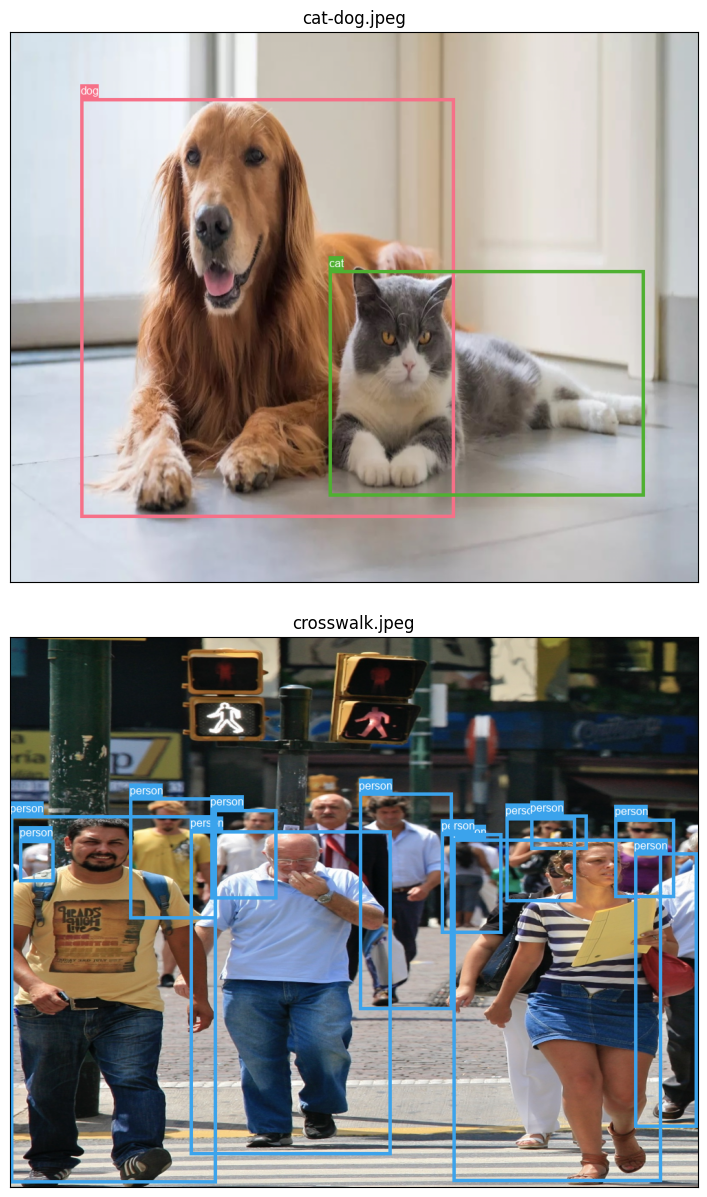

In [17]:
show_object_detections_from_df(
    df = cats_dogs_person_df, 
    stage = '@IMAGE_FILES',
    resize_shape = (800,1000),
    figsize=(20,15)
    )